In [90]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
# img_width, img_height = 224, 224
img_width, img_height = 500, 500

pretrained_model = "inceptionv3_500"
weight_folder = "inceptionv3_500_0.546275"


top_model_weights_path = '../model/bottleneck_fc_model_%s.h5'%pretrained_model
# train_data_dir = '../data/Pandora18K_small_train_val_test_split/train'
# validation_data_dir = '../data/Pandora18K_small_train_val_test_split/val'
# test_data_dir = '../data/Pandora18K_small_train_val_test_split/test'
# nb_train_samples = 1462
# nb_validation_samples = 167
# nb_test_samples = 171
train_data_dir = '../data/Pandora18K_train_val_test_split/train'
validation_data_dir = '../data/Pandora18K_train_val_test_split/val'
test_data_dir = '../data/Pandora18K_train_val_test_split/test'
nb_train_samples = 14313
nb_validation_samples = 1772
nb_test_samples = 1791







In [91]:
datagen = ImageDataGenerator(rescale=1. / 255)
# build the VGG16 network
# model = applications.VGG16(include_top=False, weights='imagenet')
model = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet')

In [92]:
from keras.utils.np_utils import to_categorical

train_data = np.load(open('../model/bottleneck_features_train_%s.npy'%pretrained_model))
#full
train_labels = np.array([0]*684+[1]*598+[2]*655+[3]*657+[4]*808+[5]*675+[6]*715+[7]*946+[8]*995+[9]*1021+[10]*803+[11]*816+[12]*566+[13]*959+[14]*842+[15]*831+[16]*849+[17]*893)

#small
#train_labels = np.array([0]*78+[1]*79+[2]*77+[3]*85+[4]*78+[5]*87+[6]*80+[7]*81+[8]*81+[9]*80+[10]*85+[11]*83+[12]*74+[13]*87+[14]*83+[15]*83+[16]*78+[17]*83)

train_labels = to_categorical(train_labels, num_classes=18)

validation_data = np.load(open('../model/bottleneck_features_validation_%s.npy'%pretrained_model))
#full
validation_labels = np.array([0]*72+[1]*73+[2]*72+[3]*93+[4]*78+[5]*74+[6]*85+[7]*124+[8]*131+[9]*118+[10]*109+[11]*105+[12]*80+[13]*130+[14]*108+[15]*89+[16]*111+[17]*120)

#small
#validation_labels = np.array([0]*8+[1]*10+[2]*11+[3]*5+[4]*11+[5]*6+[6]*8+[7]*8+[8]*9+[9]*12+[10]*7+[11]*10+[12]*14+[13]*5+[14]*11+[15]*11+[16]*12+[17]*9)
validation_labels = to_categorical(validation_labels, num_classes=18)

test_data = np.load(open('../model/bottleneck_features_test_%s.npy'%pretrained_model))
#full
test_labels = np.array([0]*91+[1]*60+[2]*75+[3]*82+[4]*104+[5]*83+[6]*95+[7]*121+[8]*131+[9]*123+[10]*103+[11]*117+[12]*65+[13]*123+[14]*121+[15]*112+[16]*89+[17]*96)

#small
#test_labels = np.array([0]*14+[1]*11+[2]*12+[3]*10+[4]*11+[5]*7+[6]*12+[7]*11+[8]*10+[9]*8+[10]*8+[11]*7+[12]*12+[13]*8+[14]*6+[15]*6+[16]*10+[17]*8)
test_labels = to_categorical(test_labels, num_classes=18)

MemoryError: 

In [93]:
def get_confusion_matrix_one_hot(model_results, truth):
    '''model_results and truth should be for one-hot format, i.e, have >= 2 columns,
    where truth is 0/1, and max along each row of model_results is model result
    '''
    assert model_results.shape == truth.shape
    num_outputs = truth.shape[1]
    confusion_matrix = np.zeros((num_outputs, num_outputs), dtype=np.int32)
    predictions = np.argmax(model_results,axis=1)
    assert len(predictions)==truth.shape[0]

    for actual_class in range(num_outputs):
        idx_examples_this_class = truth[:,actual_class]==1
        prediction_for_this_class = predictions[idx_examples_this_class]
        for predicted_class in range(num_outputs):
            count = np.sum(prediction_for_this_class==predicted_class)
            confusion_matrix[actual_class, predicted_class] = count
    assert np.sum(confusion_matrix)==len(truth)
    assert np.sum(confusion_matrix)==np.sum(truth)
    return confusion_matrix

In [94]:
import keras
import os
import pickle


batch_size = 64
#0:lr,1:dense middle,2:dropout1, 3:dropout2
# params=(1.951551576923019e-05, 650, 0.7037775003798115, 0.7698038979003217)
# params =(1.4813844087597416e-05, 593, 0.4553738549907012, 0.7257928399177316)
params = (9.872134816612904e-05, 653, 0.40977067265920386, 0.7121187929915329)
print(params)
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dropout(params[2]))#0.6
model.add(Dense(params[1], activation='relu'))#256
model.add(Dropout(params[2]))#0.6
model.add(Dense(18, activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(lr=params[0], beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                  loss='categorical_crossentropy', metrics=['accuracy'])

weight_dir = "../model/%s"%weight_folder
best_weight_path = os.path.join(weight_dir, "best_weights_%s.h5"%pretrained_model)

print(best_weight_path)
model.load_weights(best_weight_path)
  



(9.872134816612904e-05, 653, 0.40977067265920386, 0.7121187929915329)
../model/inceptionv3_500_0.546275/best_weights_inceptionv3_500.h5


In [95]:
loss, acc = model.evaluate(validation_data, validation_labels, batch_size=32, verbose=1, sample_weight=None)
acc

1772/1772 [==============================] - 5s     


0.54627539530295555

In [96]:
model_result = model.predict(validation_data, batch_size=32, verbose=1)

1772/1772 [==============================] - 6s     


In [97]:
sparse_result = np.argmax(model_result, axis=1)

one_hot_result = to_categorical(sparse_result, num_classes=18)
confusion_matrix = get_confusion_matrix_one_hot(one_hot_result, validation_labels)

print(confusion_matrix)


[[68  3  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 2 52 12  4  0  0  0  1  0  0  0  0  0  0  0  0  2  0]
 [ 0 10 42  9  5  0  0  3  0  0  0  2  0  0  1  0  0  0]
 [ 0  7 10 58 10  2  1  3  0  0  0  1  0  0  0  1  0  0]
 [ 0  0  2 10 34 16  7  2  3  0  1  2  0  0  1  0  0  0]
 [ 0  1  2  5 17 38  4  4  0  0  0  3  0  0  0  0  0  0]
 [ 0  2  2  6 10 19 24  9  5  0  1  6  0  0  0  0  1  0]
 [ 1  4  2  2  3  5  4 73 11  5  0  7  0  0  5  0  2  0]
 [ 0  0  3  1  1  1  0 19 68 20  5  9  0  0  1  0  1  2]
 [ 1  4  2  0  0  0  0  6 11 40 16 11 12  1  3  1  9  1]
 [ 1  2  5  0  1  0  0  2  3 17 38  8  7  3  6  4  8  4]
 [ 2  2  3  1  2  1  0  8  3  8  8 61  0  0  2  1  3  0]
 [ 1  0  0  1  1  0  0  0  5 19 11  1 24  3  1  3  6  4]
 [ 1  0  2  1  0  0  0  0  1  4  7  2  2 84 10  8  2  6]
 [ 2  2  2  2  0  0  0  2  1  1  2  3  2  7 48  2 20 12]
 [ 1  0  0  0  0  0  0  0  0  0  8  2  3  3  5 55  5  7]
 [ 0  1  1  0  0  0  0  1  1  9  3  1  4  5  8  2 67  8]
 [ 0  0  0  0  0  0  0  1  1  0

In [66]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[ 67   2   0   0   0   0   0   0   0   0   1   0   0   0   1   1   0   0]
 [  1  54   8   4   1   0   0   1   0   0   1   0   0   0   1   0   2   0]
 [  1   7  42   8   7   0   0   3   0   0   0   1   0   0   2   0   0   1]
 [  0   7   5  64  11   2   1   1   0   0   0   1   0   0   0   1   0   0]
 [  0   0   1   6  42  12   8   4   2   0   1   1   0   0   0   0   1   0]
 [  0   0   2   0  19  43   6   2   0   0   0   2   0   0   0   0   0   0]
 [  0   2   3   6  12  13  28  11   3   0   1   5   0   0   1   0   0   0]
 [  1   2   1   1   4   2   5  79  12   6   2   5   0   1   1   0   2   0]
 [  0   0   0   1   1   3   1  19  66  23   4   5   1   0   4   0   2   1]
 [  1   3   1   1   0   0   1   7  10  46  17   4  16   2   3   0   6   0]
 [  1   1   1   1   0   0   1   3   5  23  32   4   9   8   5   5   8   2]
 [  2   3   0   2   4   0   2   5   7   8   9  55   0   2   2   2   2   0]
 [  0   0   0   0   0   0   1   0   7  15   8   1  31   5   

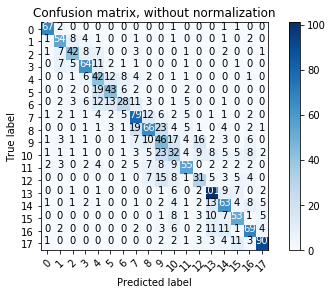

Normalized confusion matrix
[[ 0.93  0.03  0.    0.    0.    0.    0.    0.    0.    0.    0.01  0.    0.
   0.    0.01  0.01  0.    0.  ]
 [ 0.01  0.74  0.11  0.05  0.01  0.    0.    0.01  0.    0.    0.01  0.    0.
   0.    0.01  0.    0.03  0.  ]
 [ 0.01  0.1   0.58  0.11  0.1   0.    0.    0.04  0.    0.    0.    0.01
   0.    0.    0.03  0.    0.    0.01]
 [ 0.    0.08  0.05  0.69  0.12  0.02  0.01  0.01  0.    0.    0.    0.01
   0.    0.    0.    0.01  0.    0.  ]
 [ 0.    0.    0.01  0.08  0.54  0.15  0.1   0.05  0.03  0.    0.01  0.01
   0.    0.    0.    0.    0.01  0.  ]
 [ 0.    0.    0.03  0.    0.26  0.58  0.08  0.03  0.    0.    0.    0.03
   0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.02  0.04  0.07  0.14  0.15  0.33  0.13  0.04  0.    0.01  0.06
   0.    0.    0.01  0.    0.    0.  ]
 [ 0.01  0.02  0.01  0.01  0.03  0.02  0.04  0.64  0.1   0.05  0.02  0.04
   0.    0.01  0.01  0.    0.02  0.  ]
 [ 0.    0.    0.    0.01  0.01  0.02  0.01  0.15  0.5   0.18  0.03  0.0

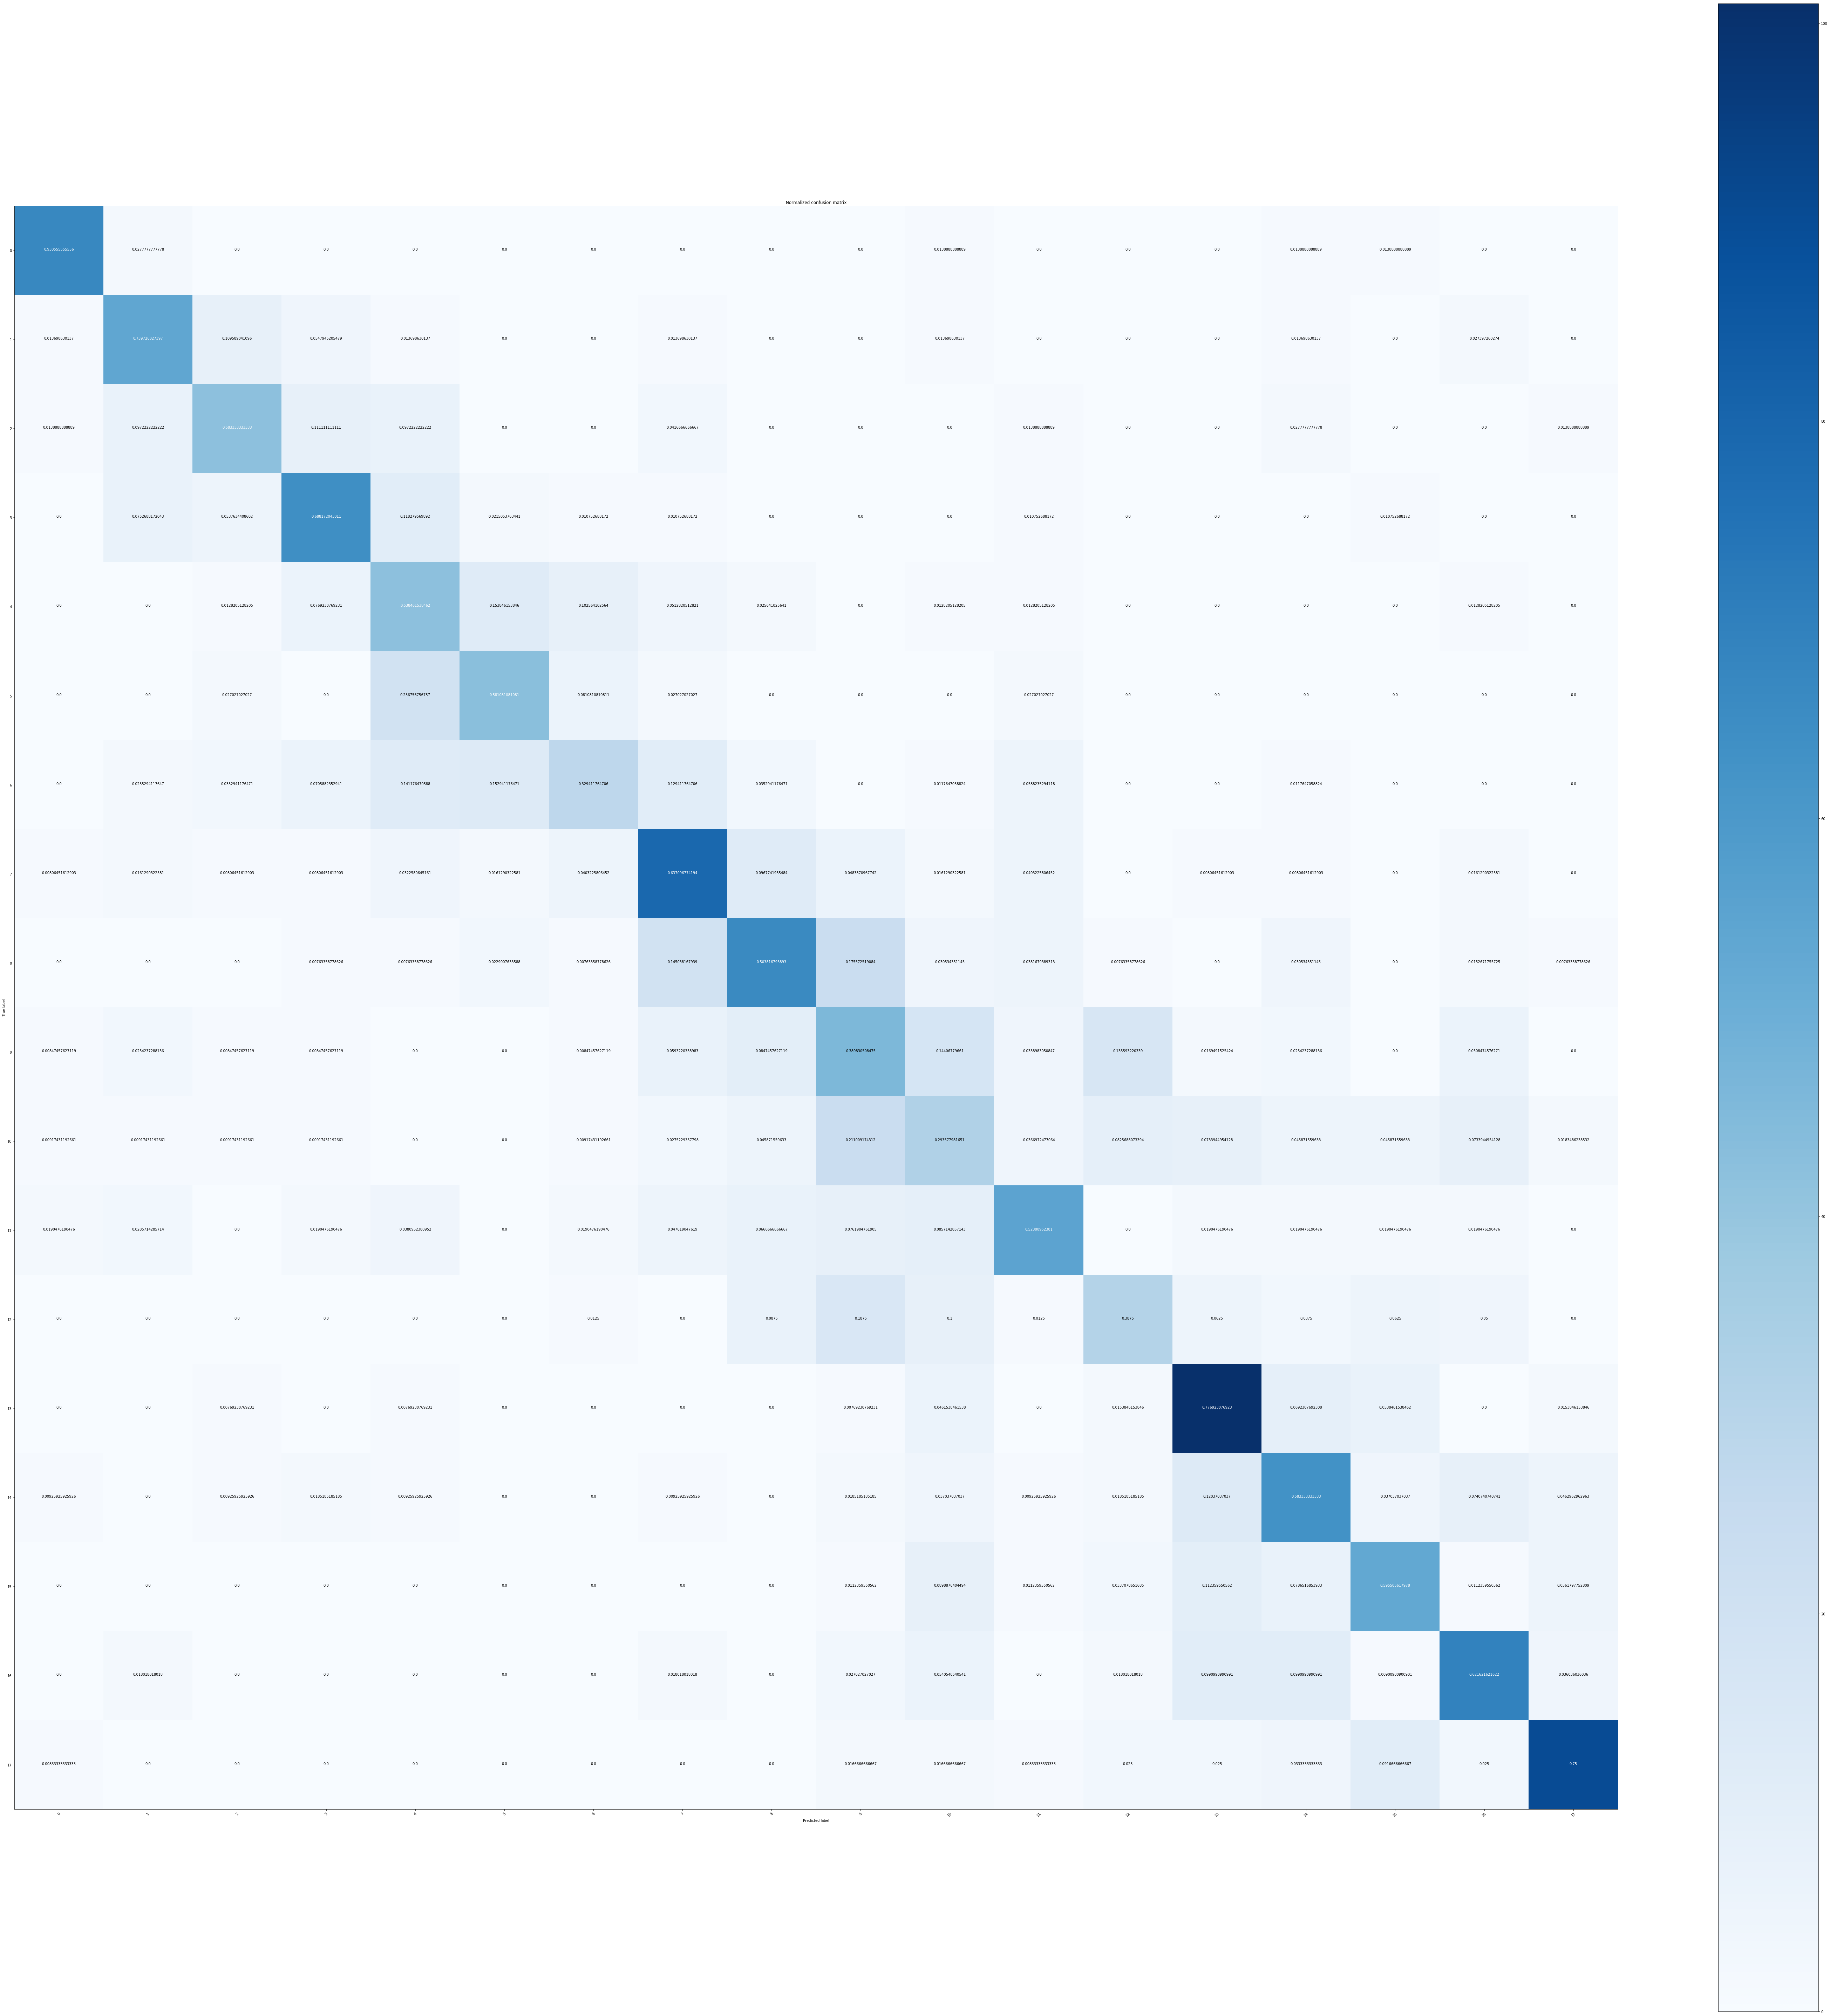

In [77]:

class_names = range(18)
plot_confusion_matrix(confusion_matrix,classes=class_names,  title='Confusion matrix, without normalization')
np.set_printoptions(precision=2)

plt.figure(figsize=(80, 80))
plt.savefig('cm_no_norm.png')
plt.show()
plt.figure(figsize=(80, 80))
plot_confusion_matrix(confusion_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('cm_with_norm.png')

plt.show()

import pickle
import os

history = pickle.load(open(os.path.join(weight_dir,'history_%s.p'%pretrained_model),'rb'))

In [8]:
validation_data.shape


(1772, 14, 14, 2048)

In [11]:
acc

0.57844243819234598